<a href="https://colab.research.google.com/github/nomadicsenseis/VisionTransformer/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vision Transformer

As I commented on my repo https://github.com/nomadicsenseis/annoted-transformer, since their first appearenace in 2017 Transformers have taken oer the NLP world. But they were not done yet. Afer some attempts of deploying them in tandem with CNNs, Google (https://arxiv.org/abs/2010.11929) finally published a paper where they implemented them directly on the task of Computer Vision. In this work I aim to recreate what they did on that paper.

As for the actual frameworks, I will go for PyTorch and AWS, more specifically I will train on a Trainnium instance using the Hugging Face's base image and the Neuron SDK; and for TensorFlow Extended (the distribute library) to train the model on a TPU in the GCP.

##Architecture


Basically, a VIT is an Encoder Transformer connected to a multilayer perceptron that outputs a label probability. As in NLP, the transformer must input some context-free representation of some kind of token, and by the end of the trainning, it should output a context representation of each of those tokens. Now, what they did in this paper is creating a series of patches out of the original images, and they used them as tokens for the encoder. There are multiple ways of creating these patches, they mentioned that it is even possible to get them as the outputs of the hidden layers of some CNNs. What is is important though, is that the number of them must be relativeley low, in orther to keep the number of computed attentions reasonable. In particular, they just divided the image into 16 x 16 patches, and then they projected each patch to the a D-length vector through a learnable linear layer. So the initial "positional+context free embedding" is learned (in contrast with the original Attention is all you need where they were hard coded).

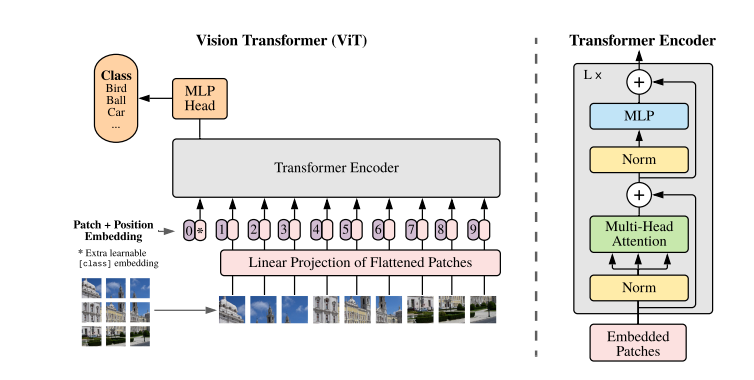

In [2]:
from IPython.display import Image
Image(filename='/content/ViTransformer.png', width=600, height=350)

###PyTorch

###TensorFlow

## Trainning

###AWS

###Google CLoud